In [1]:
%matplotlib inline
import numpy as np
import random as random
import matplotlib.pyplot as plt
import math


import warnings
warnings.simplefilter('ignore', np.RankWarning)

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd

In [2]:
location = r"E:\MYLEARN\2-ANALYTICS-DataScience\datasets\movie_metadata.csv"

In [3]:
# load the IMDB movies data 
movie_data  = pd.read_csv(location, encoding="iso-8859-1" )

In [4]:
movie_data.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [5]:
movie_data.shape

(5043, 28)

# Data Cleaning and Summary statistics

In [6]:
movie_data_cln = movie_data.copy()

In [7]:
# Drop rows with missing gross revenue data (standard practice in regression analysis)
movie_data_cln = movie_data_cln.dropna(subset = ['gross'])


In [8]:
# Only keep data on movies from the US
movie_data_cln = movie_data_cln[movie_data_cln['country'] == "USA"]

In [9]:
# Assuming a average US inflation rate of 2.5%, we convert gross revenue in terms of 2017 dollars
movie_data_cln[['gross']] = (1.025**(2017-movie_data_cln['title_year']))*movie_data_cln['gross']

In [10]:
# Only keep the variables , 'imdb_score' and 'gross'
movie_data_cln = movie_data_cln[['gross','imdb_score']]

In [11]:
# a few sample records ...
movie_data_cln.head()

,gross,imdb_score
0,9.266025e+08,7.9
1,3.960635e+08,7.1
3,5.070187e+08,8.5
5,8.265919e+07,6.6
6,4.307872e+08,6.2


In [12]:
# Let's scale the gross revenue to be in millions of dollars so its easier to read
movie_data_cln[['gross']] = movie_data_cln[['gross']]/1000000

# a few sample records ...
movie_data_cln.head()

,gross,imdb_score
0,926.602528,7.9
1,396.063473,7.1
3,507.018689,8.5
5,82.659189,6.6
6,430.787240,6.2


In [13]:
# Randomly drop 90% of the data so overfitting from high degree polynomial can be seen on scatter plot
# This is not done in practice, we are just doing it to better visualize regulization methods

# Set seed so we get same random allocation on each run of code
np.random.seed(2017)

In [14]:
# Add column vector with observations generated randomly from U[0,1] distribution
movie_data_cln["uniform"] = list(np.random.uniform(0,1, len(movie_data_cln.index)))

In [15]:
movie_data_cln.head()

,gross,imdb_score,uniform
0,926.602528,7.9,0.020960
1,396.063473,7.1,0.767070
3,507.018689,8.5,0.447920
5,82.659189,6.6,0.120542
6,430.787240,6.2,0.930773


In [16]:
movie_data_cln.shape

(3235, 3)

In [17]:
movie_data_cln = movie_data_cln[['gross','imdb_score']]


In [19]:
# Summary statistics (mean, stdev, min, max)
movie_data_cln.describe()

,gross,imdb_score
count,3235.000000,3235.000000
mean,79.764661,6.385533
std,109.842143,1.049178
min,0.001044,1.600000
25%,14.132349,5.800000
50%,44.210734,6.500000
75%,102.207258,7.100000
max,1363.206376,9.300000


The average gross sales revenue is 74 million dollars, and average imdb movie rating is 6.3 out of 10.

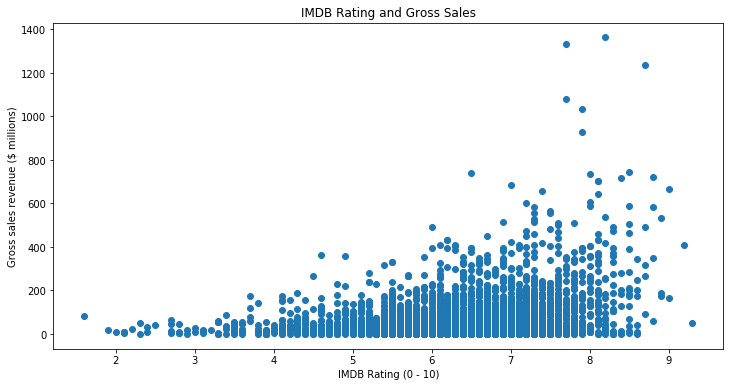

In [20]:
# Visualize data
plt.figure(figsize=(12, 6))
plt.scatter(movie_data_cln['imdb_score'], movie_data_cln['gross'])

plt.title('IMDB Rating and Gross Sales')
plt.ylabel('Gross sales revenue ($ millions)')
plt.xlabel('IMDB Rating (0 - 10)');

# Estimating linear model parameters

use well known closed form solutions to implement standard linear regression

- Let y be an n × 1 vector of observations on the dependent variable.
- Let $\epsilon$ be an n × 1 vector of disturbances or errors.
- Let β be an k × 1 vector of unknown population parameters that we want to estimate.
    
$${\begin{bmatrix} Y_1 \\ Y_2 \\ \vdots \\ \vdots \\Y_n \end{bmatrix}}_{n \> \times \> 1}
= \begin
{bmatrix} 
1 \quad {X_1}_1 \quad {X_2}_1 \quad \dots \quad {X_k}_1 \\
1 \quad {X_1}_2 \quad {X_2}_2 \quad \dots \quad {X_k}_2 \\
\dots \quad \dots \quad \dots \quad \dots \quad \dots  \\
\dots \quad \dots \quad \dots \quad \dots \quad \dots  \\
1 \quad {X_1}_n \quad {X_2}_2 \quad \dots \quad {X_k}_n \\
\end{bmatrix}_{n \> \times \> k}
.
{\begin{bmatrix} \beta_0 \\ \beta_1 \\ \vdots \\ \vdots \\\beta_k \end{bmatrix}}_{k \> \times \> 1}
+
{\begin{bmatrix} \epsilon_1 \\ \epsilon_2 \\ \vdots \\ \vdots \\\epsilon_n \end{bmatrix}}_{n \> \times \> 1}
$$

- Using outcome vector $y$, coeffecient vector $\beta$, error vector $\epsilon$, and covariate matrix $X$ (also known as design matrix), we can re-write the above equation as $y = X\beta + \epsilon.$

- the closed form solution for the parameters is $\hat{\beta} = (X'X)^{-1}X'y,$

- for the $L2$ regularized loss function the closed form solution is $\hat{\beta} = (X'X + \lambda I)^{-1}X'y,$ where I = Identity matrix

In [21]:
# Implement closed form solutions for linear and L2 norm regression
def estimate_model(y, X, Lambda):
    
    # X transpose
    Xtranspose = np.matrix.transpose(X)
    
    # Identity matrix (number of parameters is the dimension)
    Identity = np.identity(len(X[1,:]))
    
    # We don't add penalty to intercept
    Identity[0,0] = 0
    
    # Closed form solution is BetaHat = inv(X'X + Lambda*I)*X'y
    # Estimate model parameters (if Lambda = 0, we get standard square loss function result)
    BetaHat = np.dot(np.linalg.inv(np.add(np.dot(Xtranspose, X), Lambda*Identity)), np.dot(Xtranspose,y))
    
    return BetaHat

#### one degree linear regression model

In [22]:
# Estimate a one degree linear regression model (using standard square loss function)
# Simple linear regression is y = B0 + B1*x

# Define outcome vector (gross movie sales revenue)
outcome = np.array(movie_data_cln['gross'])

# Define covariate (IMDB movie rating)
imdb_score = np.array(movie_data_cln['imdb_score'])

# Vector of ones (for B0)
ones = np.ones(len(movie_data_cln))

# Define design matrix
design_simple = np.column_stack((ones,imdb_score))

# Estimate (Beta0, Beta1) for simple linear regression model
betahat_simple = estimate_model(outcome, design_simple, 0)

print (betahat_simple)


[-113.36228051   30.2444501 ]


#### five degree linear regression model 

In [23]:
# Estimate a five degree linear regression model (using standard square loss function)
# Mutiple linear regression is y = B0 + B1*x + B2*x^2 + ... + B5*x^5

# Define higher order covariates 
imdb_score2 = np.power(imdb_score, 2)
imdb_score3 = np.power(imdb_score, 3)
imdb_score4 = np.power(imdb_score, 4)
imdb_score5 = np.power(imdb_score, 5)

# Define design matrix
design_multiple = np.column_stack((ones,imdb_score, imdb_score2, imdb_score3, imdb_score4, imdb_score5))

# Estimate (Beta0, Beta1, Beta2, Beta3, Beta4, and Beta5) for multiple linear regression model
betahat_multiple = estimate_model(outcome, design_multiple, 0)
print (betahat_multiple)

[ 5.05231334e+02 -5.03825599e+02  1.86438390e+02 -2.99375619e+01
  2.00958335e+00 -3.49350789e-02]


#### Coefficient for ridge regression

In [24]:
# Estimate a L2 regularized loss function regression (also known as ridge regression)
# Multiple linear regression is y = B0 + B1*x + B2*x^2 + ... + B5*x^5

# Estimate (Beta0, Beta1, Beta2, Beta3, Beta4, and Beta5) for ridge regression
# We set Lambda = 5 as the tuning parameters for L2 regularization
betahat_multiple_L2 = estimate_model(outcome,design_multiple,5)
print (betahat_multiple_L2)

[31.73201959 -7.36011335 -8.61159504  6.47540566 -1.25123532  0.07786884]


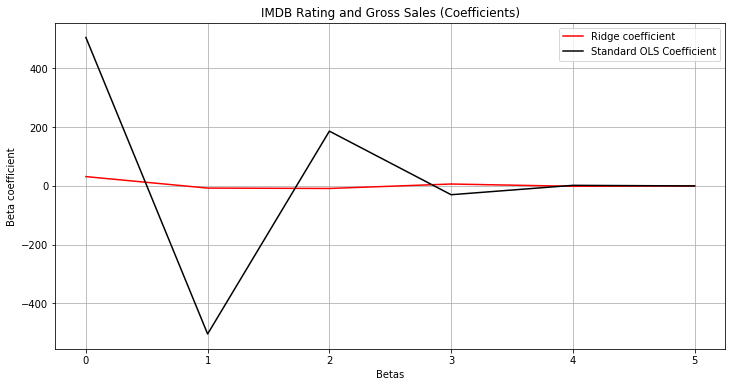

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(betahat_multiple_L2, color='r', label='Ridge coefficient')
plt.plot(betahat_multiple, color='k', label='Standard OLS Coefficient')
plt.grid()

plt.title('IMDB Rating and Gross Sales (Coefficients)')
plt.ylabel('Beta coefficient')
plt.xlabel('Betas')

plt.legend();

Notice how the estimated parameters for the ridge regression ($L2$ loss) are closer to $0$ than the estimated parameters from the multiple linear regression (standard square loss) as expected.

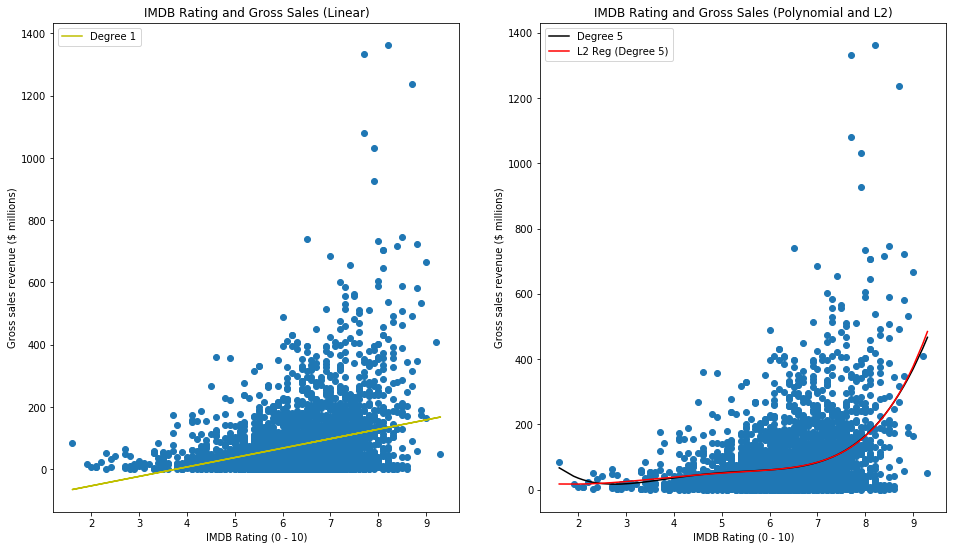

In [26]:
# Visualize simple linear regression (degree 1), figure on the left
plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
plt.scatter(movie_data_cln['imdb_score'], movie_data_cln['gross']);

# Chart title
plt.title('IMDB Rating and Gross Sales (Linear)')

# y-label
plt.ylabel('Gross sales revenue ($ millions)')

# x-label
plt.xlabel('IMDB Rating (0 - 10)')

# Plot simple linear regression (degree 1)
simple, = plt.plot(imdb_score, betahat_simple[0] + imdb_score * betahat_simple[1], 'y')

# Legend for simple linear regression scatter plot, plot on left
plt.legend([simple], ['Degree 1'])

# Visualize multiple linear regression (degree 5) and L2 loss function (degree 5), figure on the right
plt.subplot(1, 2, 2)
plt.scatter(movie_data_cln['imdb_score'], movie_data_cln['gross'])

# Chart title
plt.title('IMDB Rating and Gross Sales (Polynomial and L2)')

# y-label
plt.ylabel('Gross sales revenue ($ millions)')

# x-label
plt.xlabel('IMDB Rating (0 - 10)')

# Plot multiple linear regression (degree 5)
multiple, = plt.plot(np.sort(imdb_score), betahat_multiple[0]   + 
                     np.sort(imdb_score)*betahat_multiple[1]    + 
                     np.sort(imdb_score2) * betahat_multiple[2] + 
                     np.sort(imdb_score3)*betahat_multiple[3]   + 
                     np.sort(imdb_score4) * betahat_multiple[4] + 
                     np.sort(imdb_score5)*betahat_multiple[5],'-k')

# Plot ridge regression (L2 loss function with degree 5)
ridge,   = plt.plot(np.sort(imdb_score), betahat_multiple_L2[0]   + 
                    np.sort(imdb_score)*betahat_multiple_L2[1]    + 
                    np.sort(imdb_score2) * betahat_multiple_L2[2] + 
                    np.sort(imdb_score3) * betahat_multiple_L2[3] + 
                    np.sort(imdb_score4) * betahat_multiple_L2[4] + 
                    np.sort(imdb_score5) * betahat_multiple_L2[5],'r')

# Set legend for plot on the right
plt.legend([multiple, ridge], ['Degree 5','L2 Reg (Degree 5)']);